In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.5/612.5 kB 23.1 MB/s eta 0:00:00


In [45]:
import matplotlib.pyplot as plt

In [16]:
from ultralytics import YOLO
model = YOLO("yolov8m.pt")
import cv2
import numpy as np
from numpy.linalg import inv

bg = cv2.imread("/content/bg.jpg")

In [5]:
from google.colab.patches import cv2_imshow

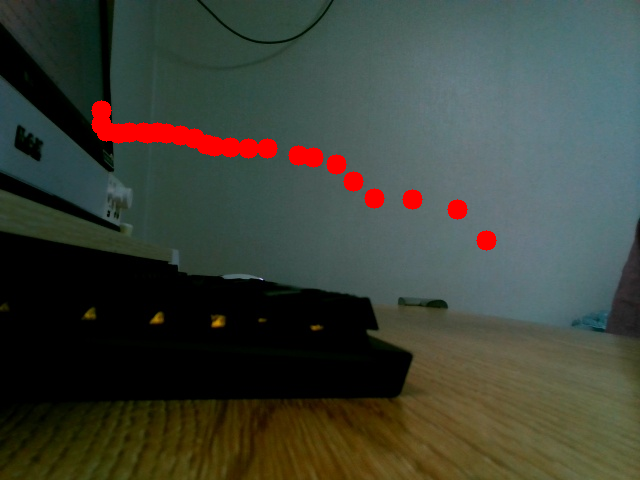

In [77]:
coord_list = [[101, 110],
 [101, 124],
 [106, 131],
 [118, 133],
 [129, 132],
 [143, 132],
 [147, 133],
 [157, 132],
 [166, 133],
 [180, 135],
 [194, 138],
 [206, 144],
 [214, 146],
 [230, 147],
 [248, 148],
 [267, 148],
 [298, 155],
 [313, 157],
 [336, 164],
 [353, 181],
 [374, 198],
 [412, 199],
 [457, 209],
 [486, 240]]

p_list = coord_list
bg_copy = bg.copy()
for p in p_list:
    cv2.circle(bg_copy, (p[0], p[1]), 10, (0, 0, 255), -1)
cv2_imshow(bg_copy)

In [71]:
n_samples = len(coord_list)
dt = 0.02

In [72]:
A = np.array([[ 1, dt,  0,  0],
              [ 0,  1,  0,  0],
              [ 0,  0,  1, dt],
              [ 0,  0,  0,  1]])
H = np.array([[ 1,  0,  0,  0],
              [ 0,  0,  1,  0]])
Q = 14.0 * np.eye(4)
R = np.array([[50,  0],
              [ 0, 50]])

# Initialization for estimation.
x_0 = np.array([0, 0, 0, 0])  # (x-pos, x-vel, y-pos, y-vel) by definition in book.
P_0 = 100 * np.eye(4)

In [73]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm."""
    # (1) Prediction.
    x_pred = A @ x_esti
    P_pred = A @ P @ A.T + Q

    # (2) Kalman Gain.
    K = P_pred @ H.T @ inv(H @ P_pred @ H.T + R)

    # (3) Estimation.
    x_esti = x_pred + K @ (z_meas - H @ x_pred)

    # (4) Error Covariance.
    P = P_pred - K @ H @ P_pred

    return x_esti, P

In [74]:
xpos_meas_save = np.zeros(n_samples)
ypos_meas_save = np.zeros(n_samples)
xpos_esti_save = np.zeros(n_samples)
ypos_esti_save = np.zeros(n_samples)

In [75]:
x_esti, P = None, None
for i in range(n_samples):
    z_meas = p_list[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(z_meas, x_esti, P)

    xpos_meas_save[i] = z_meas[0]
    ypos_meas_save[i] = z_meas[1]
    xpos_esti_save[i] = x_esti[0]
    ypos_esti_save[i] = x_esti[2]

Text(0, 0.5, 'Y-pos. [m]')

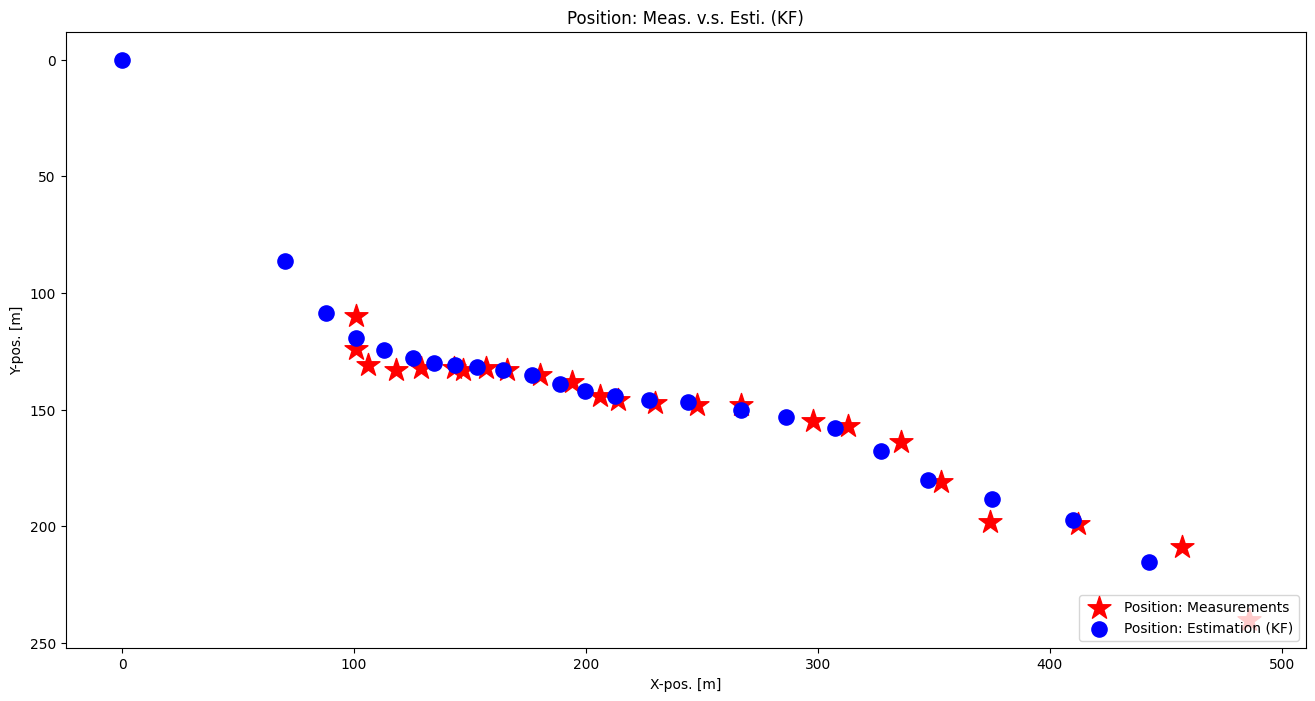

In [78]:
fig = plt.figure(figsize=(16, 8))
plt.gca().invert_yaxis()
plt.scatter(xpos_meas_save, ypos_meas_save, s=300, c="r", marker='*', label='Position: Measurements')
plt.scatter(xpos_esti_save, ypos_esti_save, s=120, c="b", marker='o', label='Position: Estimation (KF)')
plt.legend(loc='lower right')
plt.title('Position: Meas. v.s. Esti. (KF)')
plt.xlabel('X-pos. [m]')
plt.ylabel('Y-pos. [m]')

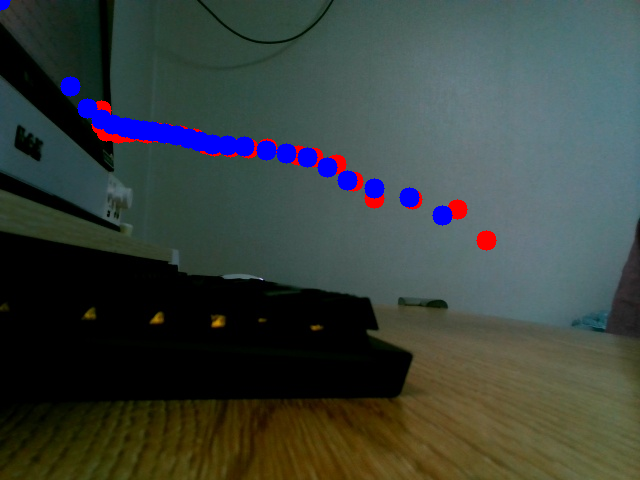

In [79]:
for i in range(n_samples):
    cv2.circle(bg_copy, (int(xpos_esti_save[i]), int(ypos_esti_save[i])), 10, (255, 0, 0), -1)
cv2_imshow(bg_copy)